<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 04: Experiment Management

### What You Will Learn

- How experiment management brings observability to ML model development
- Which features of experiment management we use in developing the Text Recognizer
- Workflows for using Weights & Biases in experiment management, including metric logging, artifact versioning, and hyperparameter optimization

# Setup

If you're running this notebook on Google Colab,
the cell below will run full environment setup.

It should take about three minutes to run.

In [5]:
lab_idx = 4

if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap

    # change into the lab directory
    bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    # allow "hot-reloading" of modules
    %load_ext autoreload
    %autoreload 2
    # needed for inline plots in some contexts
    %matplotlib inline

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

env: PYTHONPATH=.:
.:
/home/terps/.git/fsdl-text-recognizer-2022-labs/lab04
notebooks/  text_recognizer/  training/


This lab contains a large number of embedded iframes
that benefit from having a wide window.
The cell below makes the notebook as wide as your browser window
if `full_width` is set to `True`.
Full width is the default behavior in Colab,
so this cell is intended to improve the viewing experience in other Jupyter environments.

In [6]:
from IPython.display import display, HTML, IFrame

full_width = True
frame_height = 720  # adjust for your screen

if full_width:  # if we want the notebook to take up the whole width
    # add styling to the notebook's HTML directly
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

### Follow along with a video walkthrough on YouTube:

In [7]:
IFrame(src="https://fsdl.me/2022-lab-04-video-embed", width="50%", height=frame_height)

# Why experiment management?

To understand why we need experiment management for ML development,
let's start by running an experiment.

We'll train a new model on a new dataset,
using the training script `training/run_experiment.py`
introduced in [Lab 02a](https://fsdl.me/lab02a-colab).

We'll use a CNN encoder and Transformer decoder, as in
[Lab 03](https://fsdl.me/lab03-colab),
but with some changes so we can iterate faster.
We'll operate on just single lines of text at a time (`--dataclass IAMLines`), as in
[Lab02b](https://fsdl.me/lab02b-colab),
and we'll use a smaller CNN (`--modelclass LineCNNTransformer`).

In [57]:
from text_recognizer.data.iam import IAM  # base dataset of images of handwritten text
from text_recognizer.data import IAMLines  # processed version split into individual lines
from text_recognizer.models import LineCNNTransformer  # simple CNN encoder / Transformer decoder


print(IAM.__doc__)

# uncomment a line below for details on either class
# IAMLines??  
LineCNNTransformer??

A dataset of images of handwritten text written on a form underneath a typewritten prompt.

    "The IAM Lines dataset, first published at the ICDAR 1999, contains forms of unconstrained handwritten text,
    which were scanned at a resolution of 300dpi and saved as PNG images with 256 gray levels."
    From http://www.fki.inf.unibe.ch/databases/iam-handwriting-database

    Images are identified by their "form ID". These IDs are used to separate train, validation and test splits,
    as keys for dictonaries returning label and image crop region data, and more.

    The data split we will use is
    IAM lines Large Writer Independent Text Line Recognition Task (LWITLRT): 9,862 text lines.
        The validation set has been merged into the train set.
        The train set has 7,101 lines from 326 writers.
        The test set has 1,861 lines from 128 writers.
        The text lines of all data sets are mutually exclusive, thus each writer has contributed to one set only.
    


The cell below will train a model on 10% of the data for two epochs.

It takes up to a few minutes to run on commodity hardware,
including data download and preprocessing.
As it's running, continue reading below.

In [9]:
%%time
import torch


gpus = int(torch.cuda.is_available()) 

%run training/run_experiment.py --model_class LineCNNTransformer --data_class IAMLines \
  --loss transformer --batch_size 32 --gpus {gpus} --max_epochs 2 \
  --limit_train_batches 0.1 --limit_val_batches 0.1 --limit_test_batches 0.1 --log_every_n_steps 10

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type               | Params
------------------------------------------------------------------
0  | model                     | LineCNNTransformer | 4.3 M 
1  | model.line_cnn            | LineCNN            | 1.6 M 
2  | model.embedding           | Embedding          | 21.2 K
3  | model.fc                  | Linear             | 21.3 K
4  | model.pos_encoder         | PositionalEncoding | 0     
5  | model.transformer_decoder | TransformerDecoder | 2.6 M 
6  | train_acc                 | Accuracy           | 0     
7  | val_acc                   | Accuracy           | 0     
8  | test_acc      

Model State Dict Disk Size: 17.23 MB


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/cer            1.9744949340820312
        test/loss            3.235173225402832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Best model saved at: /home/terps/.git/fsdl-text-recognizer-2022-labs/lab04/training/logs/lightning_logs/version_2/epoch=0000-validation.loss=3.117-validation.cer=1.912.ckpt


CPU times: user 1min 18s, sys: 25.1 s, total: 1min 43s
Wall time: 1min 44s


As the model trains, we're calculating lots of metrics --
loss on training and validation, [character error rate](https://torchmetrics.readthedocs.io/en/v0.7.3/references/functional.html#char-error-rate-func) --
and reporting them to the terminal.

This is achieved by the built-in `.log` method
([docs](https://pytorch-lightning.readthedocs.io/en/1.6.1/common/lightning_module.html#train-epoch-level-metrics))
of the `LightningModule`,
and it is a very straightforward way to get basic information about your experiment as it's running
without leaving the context where you're running it.

Learning to read
[information from streaming numbers in the command line](http://www.quickmeme.com/img/45/4502c7603faf94c0e431761368e9573df164fad15f1bbc27fc03ad493f010dea.jpg)
is something of a rite of passage for MLEs, but
let's consider what we can't see here.

- We're missing all metric values except the most recent --
we can see them as they stream in, but they're constantly overwritten.
We also can't associate them with timestamps, steps, or epochs.

- We also don't see any system metrics.
We can't see how much the GPU is being utilized, how much CPU RAM is free, or how saturated our I/O bandwidth is
without launching a separate process.
And even if we do, those values will also not be saved and timestamped,
so we can't correlate them with other things during training.

- As we continue to run experiments, changing code and opening new terminals,
even the information we have or could figure out now will disappear.
Say you spot a weird error message during training,
but your session ends and the stdout is gone,
so you don't know exactly what it was.
Can you recreate the error?
Which git branch and commit were you on?
Did you have any uncommitted changes? Which arguments did you pass?

- Also, model checkpoints containing the parameter values have been saved to disk.
Can we relate these checkpoints to their metrics, both in terms of accuracy and in terms of performance?
As we run more and more experiments,
we'll want to slice and dice them to see if,
say, models with `--lr 0.001` are generally better or worse than models with `--lr 0.0001`.

We need to save and log all of this information, and more, in order to make our model training
[observable](https://docs.honeycomb.io/getting-started/learning-about-observability/) --
in short, so that we can understand, make decisions about, and debug our model training
by looking at logs and source code, without having to recreate it.

If we had to write the logging code we need to save this information ourselves, that'd put us in for a world of hurt:
1. That's a lot of code that's not at the core of building an ML-powered system. Robustly saving version control information means becoming _very_ good with your VCS, which is less time spent on mastering the important stuff -- your data, your models, and your problem domain.
2. It's very easy to forget to log something that you don't yet realize is going to be critical at some point. Data on netowrk traffic, disk I/O, and GPU/CPU syncing is unimportant until suddenly your training has slowed to a crawl 12 hours into training and you can't figure out where the bottleneck is.
3. Once you do start logging everything that's necessary, you might find it's not performant enough -- the code you wrote so you can debug performance issues is [tanking your performance](https://i.imgflip.com/6q54og.jpg).
4. Just logging is not enough. The bytes of data need to be made legible to humans in a GUI and searchable via an API, or else they'll be too hard to use.

# Local Experiment Tracking with Tensorboard

Luckily, we don't have to. PyTorch Lightning integrates with other libraries for additional logging features,
and it makes logging very easy.

The `.log` method of the `LightningModule` isn't just for logging to the terminal.

It can also use a logger to push information elsewhere.

By default, we use
[TensorBoard](https://www.tensorflow.org/tensorboard)
via the Lightning `TensorBoardLogger`,
which has been saving results to the local disk.

Let's find them:

In [10]:
# we use a sequence of bash commands to get the latest experiment's directory
#  by hand, you can just copy and paste it from the terminal

list_all_log_files = "find training/logs/lightning_logs/"  # find avoids issues ls has with \n in filenames
filter_to_folders = "grep '_[0-9]*$'"  # regex match on end of line
sort_version_descending = "sort -Vr"  # uses "version" sorting (-V) and reverses (-r)
take_first = "head -n 1"  # the first n elements, n=1

In [11]:
latest_log, = ! {list_all_log_files} | {filter_to_folders} | {sort_version_descending} | {take_first}
latest_log

'training/logs/lightning_logs/version_2'

In [12]:
!ls -lh {latest_log}

total 99M
-rw-r--r-- 1 terps terps  50M Oct  3 11:49 'epoch=0000-validation.loss=3.117-validation.cer=1.912.ckpt'
-rw-r--r-- 1 terps terps  50M Oct  3 11:50 'epoch=0001-validation.loss=3.117-validation.cer=1.912.ckpt'
-rw-r--r-- 1 terps terps 1.3K Oct  3 11:50  events.out.tfevents.1664815750.ThePortal.4575.0
-rw-r--r-- 1 terps terps  176 Oct  3 11:50  events.out.tfevents.1664815843.ThePortal.4575.1
-rw-r--r-- 1 terps terps    3 Oct  3 11:49  hparams.yaml


To view results, we need to launch a TensorBoard server --
much like we need to launch a Jupyter server to use Jupyter notebooks.

The cells below load an extension that lets you use TensorBoard inside of a notebook
the same way you'd use it from the command line, and then launch it.

In [13]:
%load_ext tensorboard

In [14]:
# same command works in terminal, with "{arguments}" replaced with values or "$VARIABLES"

port = 11717  # pick an open port on your machine
host = "0.0.0.0" # allow connections from the internet
                 #   watch out! make sure you turn TensorBoard off

%tensorboard --logdir {latest_log} --port {port} --host {host}

You should see some charts of metrics over time along with some charting controls.

You can click around in this interface and explore it if you'd like,
but in the next section, we'll see that there are better tools for experiment management.

If you've run many experiments on this machine,
you can see all of their results by pointing TensorBoard
at the whole `lightning_logs` directory,
rather than just one experiment:

In [58]:
%tensorboard --logdir training/logs/lightning_logs --port {port + 1} --host "0.0.0.0"

For large numbers of experiments, the management experience is not great --
it's for example hard to go from a line in a chart to metadata about the experiment or metric depicted in tha tline.

It's especially difficult to switch between types of experiments, to compare experiments run on different machines, or to collaborate with others,
which are important workflows as applications mature and teams grow.

Tensorboard is an independent service, so we need to make sure we turn it off when we're done. Just flip `done_with_tensorboard` to `True`.

If you run into any issues with the above cells failing to launch,
especially across iterations of this lab, run this cell.

In [59]:
import tensorboard.manager

# get the process IDs for all tensorboard instances
pids = [tb.pid for tb in tensorboard.manager.get_all()]

done_with_tensorboard = True

if done_with_tensorboard:
    # kill processes
    for pid in pids:
        !kill {pid} 2> /dev/null
        
    # remove the temporary files that sometimes persist, see https://stackoverflow.com/a/59582163
    !rm -rf {tensorboard.manager._get_info_dir()}

# Experiment Management with Weights & Biases

### How do we manage experiments when we hit the limits of local TensorBoard?

TensorBoard is powerful and flexible and very scalable,
but running it requires engineering effort and babysitting --
you're running a database, writing data to it,
and layering a web application over it it.

This is a fairly common workflow for web developers,
but not so much for ML engineers.

You can avoid this with [tensorboard.dev](https://tensorboard.dev/),
and it's as simple as running the command `tensorboard dev upload`
pointed at your logging directory.

But there are strict limits to this free service:
1GB of tensor data and 1GB of binary data.
A single Text Recognizer compiled model checkpoint is ~500MB,
and that's not particularly large for a useful model.

Furthermore, all data is public,
so if you upload the inputs and outputs of your model,
anyone who finds the link can see them.

Overall, tensorboard.dev works very well for certain academic and open projects
but not for industrial ML.

To avoid that narrow permissions and limits issue,
you could use [git LFS](https://git-lfs.github.com/)
to track the binary data and tensor data,
which is more likely to be sensitive than metrics.

The Hugging Face ecosystem uses TensorBoard and git LFS.

The Hugging Face Hub, a git server much like GitHub,
[will host TensorBoard alongside models](https://huggingface.co/docs/hub/tensorboard)
and officially has
[no storage limit](https://discuss.huggingface.co/t/is-there-a-size-limit-for-dataset-hosting/14861/4),
avoiding the
[tight bandwidth and storage limits](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-storage-and-bandwidth-usage),
that make using git LFS with GitHub infeasible.

Using the hub requires maintaining an additional git remote or switching from GitHub,
which is a hard ask for most engineering teams.

And furthermore, this separation is un-natural:
model binaries, metrics,
and tracked inputs/outputs
are all needed to debug model development pipelines,
and fragmenting them across services makes debugging harder.

Additionally, git-style versioning is an awkward fit for logging --
is it really sensible to create a new commit for each logging event while you're watching live?

There are multiple alternatives to TensorBoard.
The primary [open governance](https://www.ibm.com/blogs/cloud-computing/2016/10/27/open-source-open-governance/)
tool is [MLflow](https://github.com/mlflow/mlflow/)
and there are a number of
[closed-governance and/or closed-source tools](https://www.reddit.com/r/MachineLearning/comments/q5g7m9/n_sagemaker_experiments_vs_comet_neptune_wandb_etc/).

These tools generally avoid any need to worry about hosting
(unless data governance rules require a self-hosted version).

For a sampling of publicly-posted opinions on experiment management tools,
see these discussions from Reddit:

- r/mlops: [1](https://www.reddit.com/r/mlops/comments/uxieq3/is_weights_and_biases_worth_the_money/), [2](https://www.reddit.com/r/mlops/comments/sbtkxz/best_mlops_platform_for_2022/)
- r/MachineLearning: [3](https://www.reddit.com/r/MachineLearning/comments/sqa36p/comment/hwls9px/?utm_source=share&utm_medium=web2x&context=3)

Among these tools, the FSDL recommendation is
[Weights & Biases](https://wandb.ai),
which we believe offers
- the best user experience, both in the Python SDKs and in the graphical interface
- the best integrations with other tools,
including
[Lightning](https://docs.wandb.ai/guides/integrations/lightning) and
[Keras](https://docs.wandb.ai/guides/integrations/keras),
[Jupyter](https://docs.wandb.ai/guides/track/jupyter),
and even
[TensorBoard](https://docs.wandb.ai/guides/integrations/tensorboard),
and
- the best tools for collaboration.

Below, we'll take care to point out which logging and management features
are available via generic interfaces in Lightning and which are W&B-specific.

In [17]:
import wandb

print(wandb.__doc__)

Use wandb to track machine learning work.

The most commonly used functions/objects are:
  - wandb.init — initialize a new run at the top of your training script
  - wandb.config — track hyperparameters and metadata
  - wandb.log — log metrics and media over time within your training loop

For guides and examples, see https://docs.wandb.com/guides.

For scripts and interactive notebooks, see https://github.com/wandb/examples.

For reference documentation, see https://docs.wandb.com/ref/python.



Adding it to our experiment running code is extremely easy,
relative to the features we get, which is
one of the main selling points of W&B.

We get most of our new experiment management features just by changing a single variable, `logger`, from
`TensorboardLogger` to `WandbLogger`
and adding two lines of code.

In [18]:
!grep "args.wandb" -A 5 training/run_experiment.py | head -n 6

    if args.wandb:
        logger = pl.loggers.WandbLogger(log_model="all", save_dir=str(log_dir), job_type="train")
        logger.watch(model, log_freq=max(100, args.log_every_n_steps))
        logger.log_hyperparams(vars(args))
        experiment_dir = logger.experiment.dir
    callbacks += [cb.ModelSizeLogger(), cb.LearningRateMonitor()]


We'll see what each of these lines does for us below.

Note that this logger is built into and maintained by PyTorch Lightning.

In [60]:
from pytorch_lightning.loggers import WandbLogger


WandbLogger??

In order to complete the rest of this notebook,
you'll need a Weights & Biases account.

As with GitHub the free tier, for personal, academic, and open source work,
is very generous.

The Text Recognizer project will fit comfortably within the free tier.

Run the cell below and follow the prompts to log in or create an account or go
[here](https://wandb.ai/signup).

In [20]:
wandb.login()

wandb: Currently logged in as: terps. Use `wandb login --relogin` to force relogin


True

Run the cell below to launch an experiment tracked with Weights & Biases.

The experiment can take between 3 and 10 minutes to run.
In that time, continue reading below.

In [21]:
%%time
%run training/run_experiment.py --model_class LineCNNTransformer --data_class IAMLines \
  --loss transformer --batch_size 32 --gpus {gpus} --max_epochs 10 \
  --log_every_n_steps 10 --wandb --limit_test_batches 0.1 \
  --limit_train_batches 0.1 --limit_val_batches 0.1
    
last_expt = wandb.run

wandb.finish()  # necessary in this style of in-notebook experiment running, not necessary in CLI

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type               | Params
------------------------------------------------------------------
0  | model                     | LineCNNTransformer | 4.3 M 
1  | model.line_cnn            | LineCNN            | 1.6 M 
2  | model.embedding           | Embedding          | 21.2 K
3  | model.fc                  | Linear             | 21.3 K
4  | model.pos_encoder         | PositionalEncoding | 0     
5  | model.transformer_decoder | TransformerDecoder | 2.6 M 
6  | train_acc                 | Accuracy           | 0     
7  | val_acc

Model State Dict Disk Size: 17.23 MB


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/cer            1.7503788471221924
        test/loss            2.509263277053833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Best model saved at: /home/terps/.git/fsdl-text-recognizer-2022-labs/lab04/training/logs/lightning_logs/version_3/epoch=0008-validation.loss=2.421-validation.cer=0.855.ckpt
Best model also uploaded to W&B 


epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
optimizer/lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
size/mb_disk,▁
size/nparams,▁
test/cer,▁
test/loss,▁
train/loss,██▇▇▇▇▇▇▇▇██▆▄▄▃▃▃▂▂▂▂▁▂▂▂▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
validation/cer,████▇▇▁▇▁▆
validation/loss,████▄▃▂▂▁▁
epoch,10


CPU times: user 4min 58s, sys: 1min 27s, total: 6min 25s
Wall time: 7min 10s


We see some new things in our output.

For example, there's a note from `wandb` that the data is saved locally
and also synced to their servers.

There's a link to a webpage for viewing the logged data and a name for our experiment --
something like `dandy-sunset-1`.

The local logging and cloud syncing happens with minimal impact on performance,
because `wandb` launches a separate process to listen for events and upload them.

That's a table-stakes feature for a logging framework but not a pleasant thing to write in Python yourself.

## Runs

To view results, head to the link in the notebook output
that looks like "Syncing run **{adjective}-{noun}-{number}**".

There's no need to wait for training to finish.

The next sections describe the contents of that interface. You can read them while looking at the W&B interface in a separate tab or window.

For even more convenience, once training is finished we can also see the results directly in the notebook by embedding the webpage:

In [22]:
print(last_expt.url)
IFrame(last_expt.url, width="100%", height=frame_height)

https://wandb.ai/terps/fsdl-text-recognizer-2022-labs-lab04/runs/qee9gexk


We have landed on the run page
([docs](https://docs.wandb.ai/ref/app/pages/run-page)),
which collects up all of the information for a single experiment into a collection of tabs.

We'll work through these tabs from top to bottom.

Each header is also a link to the documentation for a tab.

### [Overview tab](https://docs.wandb.ai/ref/app/pages/run-page#overview-tab)
This tab has an icon that looks like `(i)` or 🛈.

The top section of this tab has high-level information about our run:
- Timing information, like start time and duration
- System hardware, hostname, and basic environment info
- Git repository link and state

This information is collected and logged automatically.

The section at the bottom contains configuration information, which here includes all CLI args or their defaults,
and summary metrics.

Configuration information is collected with `.log_hyperparams` in Lightning or `wandb.config` otherwise.

### [Charts tab](https://docs.wandb.ai/ref/app/pages/run-page#charts-tab)

This tab has a line plot icon, something like 📈.

It's also the default page you land on when looking at a W&B run.

Charts are generated for everything we `.log` from PyTorch Lightning. The charts here are interactive and editable, and changes persist.

Unfurl the "Gradients" section in this tab to check out the gradient histograms. These histograms can be useful for debugging training instability issues.

We were able to log these just by calling `wandb.watch` on our model. This is a W&B-specific feature.

### [System tab](https://docs.wandb.ai/ref/app/pages/run-page#system-tab)
This tab has computer chip icon.

It contains
- GPU metrics for all GPUs: temperature, [utilization](https://stackoverflow.com/questions/5086814/how-is-gpu-and-memory-utilization-defined-in-nvidia-smi-results), and memory allocation
- CPU metrics: memory usage, utilization, thread counts
- Disk and network I/O levels

### [Model tab](https://docs.wandb.ai/ref/app/pages/run-page#model-tab)
This tab has an undirected graph icon that looks suspiciously like a [pawnbrokers' symbol](https://en.wikipedia.org/wiki/Pawnbroker#:~:text=The%20pawnbrokers%27%20symbol%20is%20three,the%20name%20of%20Lombard%20banking.).

The information here was also generated from `wandb.watch`, and includes parameter counts and input/output shapes for all layers.

### [Logs tab](https://docs.wandb.ai/ref/app/pages/run-page#logs-tab)
This tab has an icon that looks like a stylized command prompt, `>_`.

It contains information that was printed to the stdout.

This tab is useful for, e.g., determining when exactly a warning or error message started appearing.

Note that model summary information is printed here. We achieve this with a Lightning `Callback` called `ModelSummary`. 

In [23]:
!grep "callbacks.ModelSummary" training/run_experiment.py

    summary_callback = pl.callbacks.ModelSummary(max_depth=2)


Lightning `Callback`s add extra "nice-to-have" engineering features to our model training.

For more on Lightning `Callback`s, see
[Lab 02a](https://fsdl.me/lab02a-colab).

### [Files tab](https://docs.wandb.ai/ref/app/pages/run-page#files-tab)
This tab has a stylized document icon, something like 📄.

You can use this tab to view any files saved with the `wandb.save`.

For most uses, that style is deprecated in favor of `wandb.log_artifact`,
which we'll discuss shortly.

But a few pieces of information automatically collected by W&B end up in this tab.

Some highlights:
  - Much more detailed environment info: `conda-environment.yaml` and `requirements.txt`
  - A `diff.patch` that represents the difference between the files in the `git` commit logged in the overview and the actual disk state.

### [Artifacts tab](https://docs.wandb.ai/ref/app/pages/run-page#artifacts-tab)
This tab has the database or [drum memory icon](https://stackoverflow.com/a/2822750), which looks like a cylinder of three stacked hockey pucks.

This tab contains all of the versioned binary files, aka artifacts, associated with our run.

We store two kinds of binary files
  - `run_table`s of model inputs and outputs
  - `model` checkpoints

We get model checkpoints via the built-in Lightning `ModelCheckpoint` callback, which is not specific to W&B.

In [24]:
!grep "callbacks.ModelCheckpoint" -A 9 training/run_experiment.py

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_top_k=5,
        filename=filename_format,
        monitor=goldstar_metric,
        mode="min",
        auto_insert_metric_name=False,
        dirpath=experiment_dir,
        every_n_epochs=args.check_val_every_n_epoch,
    )



The tools for working with artifacts in W&B are powerful and complex, so we'll cover them in various places throughout this notebook.

### Interactive Tables of Logged Media

Returning to the Charts tab,
notice that we have model inputs and outputs logged in structured tables
under the train, validation, and test sections.

These tables are interactive as well
([docs](https://docs.wandb.ai/guides/data-vis/log-tables)).
They support basic exploratory data analysis and are compatible with W&B's collaboration features.

In addition to charts in our run page, these tables also have their own pages inside the W&B web app.

In [25]:
table_versions_url = last_expt.url.split("runs")[0] + f"artifacts/run_table/run-{last_expt.id}-trainpredictions/"
table_data_url = table_versions_url + "v0/files/train/predictions.table.json"

print(table_data_url)
IFrame(src=table_data_url, width="100%", height=frame_height)

https://wandb.ai/terps/fsdl-text-recognizer-2022-labs-lab04/artifacts/run_table/run-qee9gexk-trainpredictions/v0/files/train/predictions.table.json


Getting this to work requires more effort and more W&B-specific code
than the other features we've seen so far.

We'll briefly explain the implementation here, for those who are interested.

We use a custom Lightning `Callback`:

In [61]:
from text_recognizer.callbacks.imtotext import ImageToTextTableLogger


ImageToTextTableLogger??

By default, Lightning returns logged information on every batch and these outputs are accumulated throughout an epoch.

The values are then aggregated with a frequency determined by the `pl.Trainer` argument `--log_every_n_batches`.

This behavior is sensible for metrics, which are low overhead, but not so much for media,
where we'd rather subsample and avoid holding on to too much information.

So we additionally control when media is included in the outputs with methods like `add_on_logged_batches`.

The frequency of media logging is then controlled with `--log_every_n_batches`, as with aggregate metric reporting.

In [62]:
from text_recognizer.lit_models.base import BaseImageToTextLitModel

BaseImageToTextLitModel.add_on_logged_batches??

## Projects

Everything we've seen so far has been related to a single run or experiment.

Experiment management starts to shine when you can organize, filter, and group many experiments at once.

We organize our runs into "projects" and view them on the  W&B "project page" 
([docs](https://docs.wandb.ai/ref/app/pages/project-page)).

By default in the Lightning integration, the project name is determined based on directory information.
This default can be over-ridden in the code when creating a `WandbLogger`,
but we find it easier to change it from the command line by setting the `WANDB_PROJECT` environment variable.

Let's see what the project page looks like for a longer-running project with lots of experiments

The cell below pulls up the project page for some of the debugging and feature addition work done while updating the course from 2021 to 2022.

In [28]:
project_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/workspace"

print(project_url)
IFrame(src=project_url, width="100%", height=720)

https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/workspace


This page and these charts have been customized -- filtering down to the most interesting training runs and surfacing the most import high-level information about them.

We welcome you to poke around in this interface: deactivate or change the filters, clicking through into individual runs, and change the charts around.

## Artifacts

Beyond logging metrics and metadata from runs,
we can also log and version large binary files, or artifacts, and their metadata ([docs](https://docs.wandb.ai/guides/artifacts/artifacts-core-concepts)).

The cell below pulls up all of the artifacts associated with the experiment we just ran.

In [29]:
IFrame(src=last_expt.url + "/artifacts", width="100%", height=frame_height)

Click on one of the `model` checkpoints -- the specific version doesn't matter.

There are a number of tabs here.

The "Overview" tab includes automatically generated metadata, like which run by which user created this model checkpoint, when, and how much disk space it takes up.

The "Metadata" tab includes configurable metadata, here hyperparameters and metrics like `validation/cer`,
which are added by default by the `WandbLogger`.

The "Files" tab contains the actual file contents of the artifact.

On the left-hand side of the page, you'll see the other versions of the model checkpoint,
including some versions that are "tagged" with version aliases, like `latest` or `best`.

You can click on these to explore the different versions and even directly compare them.

If you're particularly interested in this tool, try comparing two versions of the `validation-predictions` artifact, starting from the Files tab and clicking inside it to `validation/predictions.table.json`. 

Artifact storage is part of the W&B free tier.

The storage limits, as of August 2022, cover 100GB of Artifacts and experiment data.

The former is sufficient to store ~700 model checkpoints for the Text Recognizer.

You can track your data storage and compare it to your limits at this URL:

In [30]:
storage_tracker_url = f"https://wandb.ai/usage/{last_expt.entity}"

print(storage_tracker_url)

https://wandb.ai/usage/terps


## Programmatic Access

We can also programmatically access our data and metadata via the `wandb` API
([docs](https://docs.wandb.ai/guides/track/public-api-guide)):

In [31]:
wb_api = wandb.Api()

For example, we can access the metrics we just logged as a `pandas.DataFrame` by grabbing the run via the API:

In [32]:
run = wb_api.run("/".join( # fetch a run given
    [last_expt.entity,     # the user or org it was logged to
     last_expt.project,    # the "project", usually one of several per repo/application
     last_expt.id]         # and a unique ID
))

hist = run.history()  # and pull down a sample of the data as a pandas DataFrame

hist.head(5)

,trainer/global_step,_step,_runtime,size/nparams,size/mb_disk,_timestamp,validation/predictions,optimizer/lr-Adam,train/predictions,train/loss,...,gradients/transformer_decoder.layers.0.norm3.bias,gradients/transformer_decoder.layers.2.self_attn.in_proj_weight,gradients/transformer_decoder.layers.1.self_attn.in_proj_weight,gradients/transformer_decoder.layers.0.linear1.weight,gradients/line_cnn.convs.2.conv.weight,gradients/transformer_decoder.layers.1.norm3.weight,gradients/transformer_decoder.layers.1.self_attn.out_proj.weight,gradients/transformer_decoder.layers.1.norm2.weight,test/cer,test/loss
0,-1,0,16,4297331.0,17.22701,1664815863,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,21,NaN,NaN,1664815868,{'artifact_path': 'wandb-client-artifact://16q...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,25,NaN,NaN,1664815872,NaN,0.001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,3,27,NaN,NaN,1664815874,NaN,0.001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,4,30,NaN,NaN,1664815877,NaN,NaN,{'artifact_path': 'wandb-client-artifact://dhl...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
hist.groupby("epoch")["train/loss"].mean()

epoch
0.0     3.298734
1.0     3.213943
2.0     3.216021
3.0     3.237335
4.0     3.071682
5.0     2.770668
6.0     2.655726
7.0     2.598666
8.0     2.576380
9.0     2.536892
10.0         NaN
Name: train/loss, dtype: float64

Note that this includes the artifacts:

In [34]:
# which artifacts where created and logged?
artifacts = run.logged_artifacts()

for artifact in artifacts:
    print(f"artifact of type {artifact.type}: {artifact.name}")

artifact of type run_table: run-qee9gexk-validationpredictions:v0
artifact of type run_table: run-qee9gexk-trainpredictions:v0
artifact of type run_table: run-qee9gexk-trainpredictions:v1
artifact of type run_table: run-qee9gexk-validationpredictions:v1
artifact of type model: model-qee9gexk:v0
artifact of type run_table: run-qee9gexk-trainpredictions:v2
artifact of type run_table: run-qee9gexk-trainpredictions:v3
artifact of type run_table: run-qee9gexk-trainpredictions:v4
artifact of type run_table: run-qee9gexk-validationpredictions:v2
artifact of type model: model-qee9gexk:v1
artifact of type run_table: run-qee9gexk-trainpredictions:v5
artifact of type run_table: run-qee9gexk-trainpredictions:v6
artifact of type run_table: run-qee9gexk-trainpredictions:v7
artifact of type run_table: run-qee9gexk-validationpredictions:v3
artifact of type model: model-qee9gexk:v2
artifact of type run_table: run-qee9gexk-trainpredictions:v8
artifact of type run_table: run-qee9gexk-trainpredictions:v9


Thanks to our `ImageToTextTableLogger`,
we can easily recreate training or validation data that came out of our `DataLoader`s,
which is normally ephemeral:

In [35]:
from pathlib import Path

artifact = wb_api.artifact(f"{last_expt.entity}/{last_expt.project}/run-{last_expt.id}-trainpredictions:latest")
artifact_dir = Path(artifact.download(root="training/logs"))
image_dir = artifact_dir / "media" / "images"

images = [path for path in image_dir.iterdir()]

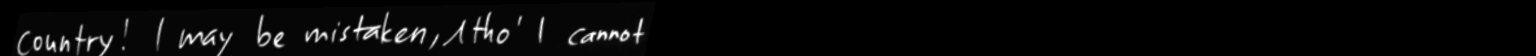

In [36]:
import random

from IPython.display import Image

Image(str(random.choice(images)))

#### Advanced W&B API Usage: MLOps

One of the strengths of a well-instrumented experiment tracking system is that it allows
automatic relation of information:
what were the inputs when this model's gradient spiked?
which models have been trained on this dataset,
and what was their performance?

Having access and automation around this information is necessary for "MLOps",
which applies contemporary DevOps principles to ML projects.

The cells below pull down the training data
for the model currently running the FSDL Text Recognizer app.

This is just intended as a demonstration of what's possible,
so don't worry about understanding every piece of this,
and feel free to skip past it.

MLOps is still a nascent field, and these tools and workflows are likely to change.

For example, just before the course launched, W&B released a
[Model Registry layer](https://docs.wandb.ai/guides/models)
on top of artifact logging that aims to improve the developer experience for these workflows.

We start from the same project we looked at in the project view:

In [37]:
text_recognizer_project = wb_api.project("fsdl-text-recognizer-2021-training", entity="cfrye59")

text_recognizer_project  

<Project cfrye59/fsdl-text-recognizer-2021-training>

and then we search it for the text recognizer model currently being used in production:

In [38]:
# collect all versions of the text-recognizer ever put into production by...

for art_type in text_recognizer_project.artifacts_types(): # looking through all artifact types
    if art_type.name == "prod-ready":  # for the prod-ready type
        # and grabbing the text-recognizer
        production_text_recognizers = art_type.collection("paragraph-text-recognizer").versions()

# and then get the one that's currently being tested in CI by...
for text_recognizer in production_text_recognizers:
    if "ci-test" in text_recognizer.aliases:  # looking for the one that's labeled as CI-tested
        in_prod_text_recognizer = text_recognizer

# view its metadata at the url or in the notebook
in_prod_text_recognizer_url = text_recognizer_project.url[:-9] + f"artifacts/{in_prod_text_recognizer.type}/{in_prod_text_recognizer.name.replace(':', '/')}"

print(in_prod_text_recognizer_url)
IFrame(src=in_prod_text_recognizer_url, width="100%", height=frame_height)

https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/artifacts/prod-ready/paragraph-text-recognizer/v8


From its metadata, we can get information about how it was "staged" to be put into production,
and in particular which model checkpoint was used:

In [39]:
staging_run = in_prod_text_recognizer.logged_by()

training_ckpt, = [at for at in staging_run.used_artifacts() if at.type == "model"]
training_ckpt.name

'model-1vrnrd8p:v41'

That checkpoint was logged by a training experiment, which is available as metadata.

We can look at the training run for that model, either here in the notebook or at its URL:

In [40]:
training_run = training_ckpt.logged_by()
print(training_run.url)
IFrame(src=training_run.url, width="100%", height=frame_height)

https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/runs/1vrnrd8p


And from there, we can access logs and metadata about training,
confident that we are working with the model that is actually in production.

For example, we can pull down the data we logged and analyze it locally.

In [41]:
training_results = training_run.history(samples=10000)
training_results.head()

,trainer/global_step,_step,_runtime,size/nparams,size/mb_disk,_timestamp,validation/predictions,optimizer/lr-Adam,gradients/encoder_projection.weight,gradients/transformer_decoder.layers.0.linear2.bias,...,gradients/transformer_decoder.layers.1.self_attn.out_proj.weight,gradients/resnet.4.1.bn2.bias,gradients/transformer_decoder.layers.1.norm2.weight,train/predictions,train/loss,epoch,validation/cer,validation/loss,test/cer,test/loss
0,-1,0,98,13988756.0,56.064631,1654129282,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,133,NaN,NaN,1654129317,"{'size': 34810, '_latest_artifact_path': 'wand...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,133,NaN,NaN,1654129317,NaN,0.0001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39,3,159,NaN,NaN,1654129343,NaN,0.0001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78,4,177,NaN,NaN,1654129361,NaN,0.0001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


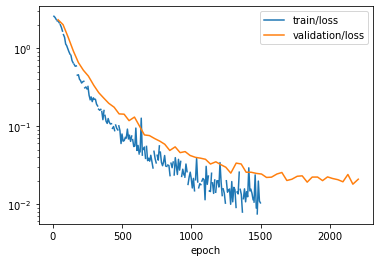

In [42]:
ax = training_results.groupby("epoch")["train/loss"].mean().plot();
training_results["validation/loss"].dropna().plot(logy=True); ax.legend();

In [43]:
idx = 10
training_results["validation/loss"].dropna().iloc[10]

0.19675205647945404

## Reports

The charts and webpages in Weights & Biases
are substantially more useful than ephemeral stdouts or raw logs on disk.

If you're spun up on the project,
they accelerate debugging, exploration, and discovery.

If not, they're not so much useful as they are overwhelming.

We need to synthesize the raw logged data into information.
This helps us communicate our work with other stakeholders,
preserve knowledge and prevent repetition of work,
and surface insights faster.

These workflows are supported by the W&B Reports feature
([docs here](https://docs.wandb.ai/guides/reports)),
which mix W&B charts and tables with explanatory markdown text and embeds.

Below are some common report patterns and
use cases and examples of each.

Some of the examples are from the FSDL Text Recognizer project.
You can find more of them
[here](https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/reports/-Report-of-Reports---VmlldzoyMjEwNDM5),
where we've organized them into a report!

### Dashboard Report

Dashboards are a structured subset of the output from one or more experiments,
designed for quickly surfacing issues or insights,
like an accuracy or performance regression
or a change in the data distribution.

Use cases:
- show the basic state of ongoing experiment
- compare one experiment to another
- select the most important charts so you can spin back up into context on a project more quickly

In [44]:
dashboard_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/reports/Training-Run-2022-06-02--VmlldzoyMTAyOTkw"

IFrame(src=dashboard_url, width="100%", height=frame_height)

### Pull Request Documentation Report

In most software codebases,
pull requests are a key focal point
for units of work that combine
short-term communication and long-term information tracking.

In ML codebases, it's more difficult to bring
sufficient information together to make PRs as useful.
At FSDL, we like to add documentary
reports with one or a small number of charts
that connect logged information in the experiment management system
to state in the version control software.

Use cases:
- communication of results within a team, e.g. code review
- record-keeping that links pull request pages to raw logged info and makes it discoverable
- improving confidence in PR correctness

In [45]:
bugfix_doc_url = "https://wandb.ai/cfrye59/fsdl-text-recognizer-2021-training/reports/Overfit-Check-After-Refactor--VmlldzoyMDY5MjI1"

IFrame(src=bugfix_doc_url, width="100%", height=frame_height)

### Blog Post Report

With sufficient effort, the logged data in the experiment management system
can be made clear enough to be consumed,
sufficiently contextualized to be useful outside the team, and
even beautiful.

The result is a report that's closer to a blog post than a dashboard or internal document.

Use cases:
- communication between teams or vertically in large organizations
- external technical communication for branding and recruiting
- attracting users or contributors

Check out this example, from the Craiyon.ai / DALL·E Mini project, by FSDL alumnus
[Boris Dayma](https://twitter.com/borisdayma)
and others:

In [46]:
dalle_mini_blog_url = "https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-Mini-Explained-with-Demo--Vmlldzo4NjIxODA#training-dall-e-mini"

IFrame(src=dalle_mini_blog_url, width="100%", height=frame_height)

# Hyperparameter Optimization

Many of our choices, like the depth of our network, the nonlinearities of our layers,
and the learning rate and other parameters of our optimizer, cannot be
([easily](https://arxiv.org/abs/1606.04474))
chosen by descent of the gradient of a loss function.

But these parameters that impact the values of the parameters
we directly optimize with gradients, or _hyperparameters_,
can still be optimized,
essentially by trying options and selecting the values that worked best.

In general, you can attain much of the benefit of hyperparameter optimization with minimal effort.

Expending more compute can squeeze small amounts of additional validation or test performance
that makes for impressive results on leaderboards but typically doesn't translate
into better user experience.

In general, the FSDL recommendation is to use the hyperparameter optimization workflows
built into your other tooling.

Weights & Biases makes the most straightforward forms of hyperparameter optimization trivially easy
([docs](https://docs.wandb.ai/guides/sweeps)).

It also supports a number of more advanced tools, like
[Hyperband](https://docs.wandb.ai/guides/sweeps/configuration#early_terminate)
for early termination of poorly-performing runs.

We can use the same training script and we don't need to run an optimization server.

We just need to write a configuration yaml file
([docs](https://docs.wandb.ai/guides/sweeps/configuration)),
like the one below.

In [47]:
%%writefile training/simple-overfit-sweep.yaml
# first we specify what we're sweeping
# we specify a program to run
program: training/run_experiment.py
# we optionally specify how to run it, including setting default arguments
command:  
    - ${env}
    - ${interpreter}
    - ${program}
    - "--wandb"
    - "--overfit_batches"
    - "1"
    - "--log_every_n_steps"
    - "25"
    - "--max_epochs"
    - "100"
    - "--limit_test_batches"
    - "0"
    - ${args}  # these arguments come from the sweep parameters below

# and we specify which parameters to sweep over, what we're optimizing, and how we want to optimize it
method: random  # generally, random searches perform well, can also be "grid" or "bayes"
metric:
    name: train/loss
    goal: minimize
parameters:  
    # LineCNN hyperparameters
    window_width:
        values: [8, 16, 32, 64]
    window_stride:
        values: [4, 8, 16, 32]
    # Transformer hyperparameters
    tf_layers:
        values: [1, 2, 4, 8]
    # we can also fix some values, just like we set default arguments
    gpus:
        value: 1
    model_class:
        value: LineCNNTransformer
    data_class:
        value: IAMLines
    loss:
        value: transformer

Writing training/simple-overfit-sweep.yaml


Based on the config we launch a "controller":
a lightweight process that just decides what hyperparameters to try next
and coordinates the heavierweight training.

This lives on the W&B servers, so there are no headaches about opening ports for communication,
cleaning up when it's done, etc.

In [48]:
!wandb sweep training/simple-overfit-sweep.yaml --project fsdl-line-recognizer-2022
simple_sweep_id = wb_api.project("fsdl-line-recognizer-2022").sweeps()[0].id

wandb: Creating sweep from: training/simple-overfit-sweep.yaml
wandb: Created sweep with ID: t81ogjf2
wandb: View sweep at: https://wandb.ai/terps/fsdl-line-recognizer-2022/sweeps/t81ogjf2
wandb: Run sweep agent with: wandb agent terps/fsdl-line-recognizer-2022/t81ogjf2


and then we can launch an "agent" to follow the orders of the controller:

In [63]:
%%time

# interrupt twice to terminate this cell if it's running too long,
#   it can be over 15 minutes with some hyperparameters

!wandb agent --project fsdl-line-recognizer-2022 --entity {wb_api.default_entity} --count=1 {simple_sweep_id}

wandb: Starting wandb agent 🕵️
2022-10-03 14:04:25,181 - wandb.wandb_agent - INFO - Running runs: []
2022-10-03 14:04:25,648 - wandb.wandb_agent - INFO - Agent received command: run
2022-10-03 14:04:25,649 - wandb.wandb_agent - INFO - Agent starting run with config:
	data_class: IAMLines
	gpus: 1
	loss: transformer
	model_class: LineCNNTransformer
	tf_layers: 8
	window_stride: 4
	window_width: 8
2022-10-03 14:04:25,652 - wandb.wandb_agent - INFO - About to run command: /usr/bin/env python training/run_experiment.py --wandb --overfit_batches 1 --log_every_n_steps 25 --max_epochs 100 --limit_test_batches 0 --data_class=IAMLines --gpus=1 --loss=transformer --model_class=LineCNNTransformer --tf_layers=8 --window_stride=4 --window_width=8
wandb: Currently logged in as: terps. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.13.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.12.17
wandb: Run data is sa

Epoch 0:   0%|          | 0/1 [00:03<?, ?it/s]                                  
2022-10-03 14:04:51,077 - wandb.wandb_agent - INFO - Cleaning up finished run: 16o2dyrt
wandb: Terminating and syncing runs. Press ctrl-c to kill.
wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:   optimizer/lr-Adam ▁
wandb:        size/mb_disk ▁
wandb:        size/nparams ▁
wandb: trainer/global_step ▁█
wandb: 
wandb: Run summary:
wandb:   optimizer/lr-Adam 0.001
wandb:        size/mb_disk 25.97182
wandb:        size/nparams 6476403
wandb: trainer/global_step 0
wandb: 
wandb: Synced light-sweep-2: https://wandb.ai/terps/fsdl-line-recognizer-2022/runs/16o2dyrt
wandb: Synced 3 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: training/logs/wandb/run-20221003_140429-16o2dyrt/logs
CPU times: user 1.47 s, sys: 633 ms, total: 2.1 s
Wall time: 38.

The above cell runs only a single experiment, because we provided the `--count` argument with a value of `1`.

If not provided, the agent will run forever for random or Bayesian sweeps
or until the sweep is terminated, which can be done from the W&B interface.

The agents make for a slick workflow for distributing sweeps across GPUs.

We can just change the `CUDA_VISIBLE_DEVICES` environment variable,
which controls which GPUs are accessible by a process, to launch
parallel agents on separate GPUs on the same machine.

```
CUDA_VISIBLE_DEVICES=0 wandb agent $SWEEP_ID
# open another terminal
CUDA_VISIBLE_DEVICES=1 wandb agent $SWEEP_ID
# and so on
```

# Exercises

We include optional exercises with the labs for learners who want to dive deeper on specific topics.

### 🌟Contribute to a hyperparameter search.

We've kicked off a big hyperparameter search on the `LineCNNTransformer` that anyone can join!

There are ~10,000,000 potential hyperparameter combinations,
and each takes 30 minutes to test,
so checking each possiblity will take over 500 years of compute time.
Best get cracking then!

Run the cell below to pull up a dashboard and print the URL where you can check on the current status.

In [50]:
sweep_entity = "fullstackdeeplearning"
sweep_project = "fsdl-line-recognizer-2022"
sweep_id = "e0eo43eu"
sweep_url = f"https://wandb.ai/{sweep_entity}/{sweep_project}/sweeps/{sweep_id}"

print(sweep_url)
IFrame(src=sweep_url, width="100%", height=frame_height)

https://wandb.ai/fullstackdeeplearning/fsdl-line-recognizer-2022/sweeps/e0eo43eu


We can also retrieve information about the sweep from the API,
including the hyperparameters being swept over.

In [51]:
sweep_info = wb_api.sweep("/".join([sweep_entity, sweep_project, sweep_id]))

In [52]:
hyperparams = sweep_info.config["parameters"]
hyperparams

{'batch_size': {'values': [8, 16, 64]},
 'conv_dim': {'values': [16, 32, 64, 128]},
 'fc_dim': {'values': [32, 128, 512, 1024]},
 'fc_dropout': {'values': [0, 0.05, 0.25, 0.5]},
 'gpus': {'value': 1},
 'loss': {'value': 'transformer'},
 'lr': {'values': ['1e-06', '1e-05', 0.0001, 0.001]},
 'max_epochs': {'value': -1},
 'max_time': {'value': '00:00:30:00'},
 'tf_dim': {'values': [4, 16, 64, 256]},
 'tf_dropout': {'values': [0, 0.05, 0.25, 0.5]},
 'tf_fc_dim': {'values': [4, 16, 64, 256]},
 'tf_layers': {'values': [1, 2, 4, 8]},
 'tf_nhead': {'values': [2, 4]},
 'window_stride': {'values': [4, 8, 16, 32]},
 'window_width': {'values': [8, 16, 32, 64]}}

If you'd like to contribute to this sweep,
run the cell below after changing the count to a number greater than 0.

Each iteration runs for 30 minutes if it does not crash,
e.g. due to out-of-memory errors.

In [53]:
count = 0  # off by default, increase it to join in!

if count:
    !wandb agent {sweep_id} --entity {sweep_entity} --project {sweep_project} --count {count}

### 🌟🌟 Write some manual logging in `wandb`.

In the FSDL Text Recognizer codebase,
we almost exclusively log to W&B through Lightning,
rather than through the `wandb` Python SDK.

If you're interested in learning how to use W&B directly, e.g. with another training framework,
try out this quick exercise that introduces the key players in the SDK.

The cell below starts a run with `wandb.init` and provides configuration hyperparameters with `wandb.config`.

It also calculates a `loss` value and saves a text file, `logs/hello.txt`.

Add W&B metric and artifact logging to this cell:
- use [`wandb.log`](https://docs.wandb.ai/guides/track/log) to log the loss on each step
- use [`wandb.log_artifact`](https://docs.wandb.ai/guides/artifacts) to save `logs/hello.txt` in an artifact with the name `hello` and whatever type you wish

In [76]:
import math
import os
import random

import wandb


os.makedirs("logs", exist_ok=True)

project = "trying-wandb"
config = {"steps": 50}


with wandb.init(project=project, config=config) as run:
    steps = wandb.config["steps"]
    
    for ii in range(steps):
        loss = math.exp(-ii) + random.random() / (ii + 1)  # ML means making the loss go down
        wandb.log({'loss': loss})
        
    with open("logs/hello.txt", "w") as f:
        f.write("hello from wandb, my dudes!")
    
    artifact = wandb.Artifact('hello', type='dataset')
    run.log_artifact(artifact)
        
        
    run_id = run.id

loss,█▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00513


If you've correctly completed the exercise, the cell below will print only 🥞 emojis and no 🥲s before opening the run in an iframe.

In [77]:
hello_run = wb_api.run(f"{project}/{run_id}")

# check for logged loss data
if "loss" not in hello_run.history().keys():
    print("loss not logged 🥲")
else:
    print("loss logged successfully 🥞")
    if len(hello_run.history()["loss"]) != steps:
        print("loss not logged on all steps 🥲")
    else:
        print("loss logged on all steps 🥞")

artifacts =  hello_run.logged_artifacts()

# check for artifact with the right name
if "hello:v0" not in [artifact.name for artifact in artifacts]:
    print("hello artifact not logged 🥲")
else:
    print("hello artifact logged successfully 🥞")
    # check for the file inside the artifacts
    if "hello.txt" not in sum([list(artifact.manifest.entries.keys()) for artifact in artifacts], []):
        print("could not find hello.txt 🥲")
    else:
        print("hello.txt logged successfully 🥞")
    
    
hello_run

loss logged successfully 🥞
loss logged on all steps 🥞
hello artifact not logged 🥲


<Run terps/trying-wandb/3u8xlk0i (finished)>

### 🌟🌟 Find good hyperparameters for the `LineCNNTransformer`.

The default hyperparameters for the `LineCNNTransformer` are not particularly carefully tuned.

Try and find some better hyperparameters: choices that achieve a lower loss on the full dataset faster.

If you observe interesting phenomena during training,
from promising hyperparameter combos to software bugs to strange model behavior,
turn the charts into a W&B report and share it with the FSDL community or
[open an issue on GitHub](https://github.com/full-stack-deep-learning/fsdl-text-recognizer-2022/issues)
with a link to them.

In [56]:
# check the sweep_info.config above to see the model and data hyperparameters
#   read through the --help output for all potential arguments
%run training/run_experiment.py --model_class LineCNNTransformer --data_class IAMLines \
  --loss transformer --batch_size 32 --gpus {gpus} --max_epochs 5 \
  --log_every_n_steps 50 --wandb --limit_test_batches 0.1 \
  --limit_train_batches 0.1 --limit_val_batches 0.1 \
  --help  # remove this line to run an experiment instead of printing help
    
last_hyperparam_expt = wandb.run  # in case you want to pull URLs, look up in API, etc., as in code above

wandb.finish()

usage: run_experiment.py [--logger [LOGGER]]
                         [--checkpoint_callback [CHECKPOINT_CALLBACK]]
                         [--enable_checkpointing [ENABLE_CHECKPOINTING]]
                         [--default_root_dir DEFAULT_ROOT_DIR]
                         [--gradient_clip_val GRADIENT_CLIP_VAL]
                         [--gradient_clip_algorithm GRADIENT_CLIP_ALGORITHM]
                         [--process_position PROCESS_POSITION]
                         [--num_nodes NUM_NODES]
                         [--num_processes NUM_PROCESSES] [--devices DEVICES]
                         [--gpus GPUS] [--auto_select_gpus [AUTO_SELECT_GPUS]]
                         [--tpu_cores TPU_CORES] [--ipus IPUS]
                         [--log_gpu_memory LOG_GPU_MEMORY]
                         [--progress_bar_refresh_rate PROGRESS_BAR_REFRESH_RATE]
                         [--enable_progress_bar [ENABLE_PROGRESS_BAR]]
                         [--overfit_batches OVERFIT_BATCHES]
   

<Figure size 432x288 with 0 Axes>

### 🌟🌟🌟 Add logging of tensor statistics.

In addition to logging model inputs and outputs as human-interpretable media,
it's also frequently useful to see information about their numerical values.

If you're interested in learning more about metric calculation and logging with Lightning,
use [`torchmetrics`](https://torchmetrics.readthedocs.io/en/v0.7.3/)
to add tensor statistic logging to the `LineCNNTransformer`.

`torchmetrics` comes with built in statistical metrics, like `MinMetric`, `MaxMetric`, and `MeanMetric`.

All three are useful, but start by adding just one.

To use your metric with `training/run_experiment.py`, you'll need to open and edit the `text_recognizer/lit_model/base.py` and `text_recognizer/lit_model/transformer.py` files
- Add the metrics to the `BaseImageToTextLitModel`'s `__init__` method, around where `CharacterErrorRate` appears.
  - You'll also need to decide whether to calculate separate train/validation/test versions. Whatever you do, start by implementing just one.
- In the appropriate `_step` methods of the `TransformerLitModel`, add metric calculation and logging for `Min`, `Max`, and/or `Mean`.
  - Base your code on the calculation and logging of the `val_cer` metric.
  - `sync_dist=True` is only important in distributed training settings, so you might not notice any issues regardless of that argument's value.

For an extra challenge, use `MeanSquaredError` to implement a `VarianceMetric`. _Hint_: one way is to use `torch.zeros_like` and `torch.mean`.